In [1]:
from tools import *

/home/caron/Bureau/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### EVALUATE GROUND TRUTH ON FULL DATASET

In [85]:
def order_class(n_class, predictor, dico, departement):
    classes = np.arange(n_class)
    cc = predictor.kmeans.cluster_centers_.reshape(-1)
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    res = {}
    #print(cc, classes)
    for c in range(n_class):
        if classes[c] in dico[departement].keys():
            res[c] = dico[departement][classes[c]]
        else:
            res[c] = (0, 0, 0)
    return res

def class_risk(ypred, ytrue, ybin, nameDep : str, predictor) -> dict:
    if torch.is_tensor(ypred):
        ypred = ypred.detach().cpu().numpy().astype(float)
    if torch.is_tensor(ytrue):
        ytrue = ytrue.detach().cpu().numpy().astype(float)

    res = {}

    yclass = predictor.predict(ytrue)
    uniqueClass = np.unique(yclass)
    res[nameDep] = {}
    for c in uniqueClass:
        classIndex = np.argwhere(yclass == c)
        classPred = ypred[classIndex]
        classTrue = ypred[classIndex]
        error = abs(classPred - classTrue)
        classBin = ybin[classIndex]
        meanF = round(np.mean(classBin), 3)
        meanFF = round(100 * (classBin.sum() / ybin.sum()))
        meanP = round(np.mean(classPred), 3)
        meanT = round(np.mean(classTrue), 3)
        error = round(np.mean(error))
        res[nameDep][c] = (round(predictor.get_centroid(c)[0], 3), meanP, meanT, error, meanFF, meanF)
        
    return res

def my_f1_score(Y : np.array, ypred : np.array, isBin : bool, weights : np.array = None):
    
    ytrue = Y[:,-2] > 0
    ytrueReg = Y[:,-1]

    bounds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    bestScores = []
    precs = []
    recs = []
    bestBounds = []
    values = []

    ydep = np.unique(Y[:, 3])

    for d in ydep:
        mask = np.argwhere(Y[:, 3] == d)[:, 0]
        if torch.is_tensor(ypred):
            ypredNumpy = ypred.detach().cpu().numpy()[mask]
        else:
            ypredNumpy = ypred[mask]
            
        if torch.is_tensor(ytrue): 
            ytrueNumpy = ytrue.detach().cpu().numpy()[mask]
            ytrueRegNumpy = ytrueReg.detach().cpu().numpy()[mask]
        else:
            ytrueNumpy = ytrue[mask]
            ytrueRegNumpy = ytrueReg[mask]
        
        if isBin:
            maxi = 1.0
        else:
            maxi = np.nanmax(Y[mask, -1])
        
        if weights is not None:
            if torch.is_tensor(weights):
                weightsNumpy = weights.detach().cpu().numpy()[mask]
            else:
                weightsNumpy = weights[mask]
            weightsNumpy[np.argwhere(ytrue[mask] == 0)[:,0]] = 1
        else:
            weightsNumpy = np.ones(ytrueNumpy.shape[0])

        bestScore = 0.0
        prec = 0.0
        rec = 0.0
        bestBound = 0.0

        for bound in bounds:
            if isBin:
                yBinPred = (ypredNumpy > bound * maxi).astype(int)
            else:
                yBinPred = (ytrueRegNumpy > bound * maxi).astype(int)

            f1 = f1_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)
            if f1 > bestScore:
                bestScore = f1
                bestBound =  bound
                prec = precision_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)
                rec = recall_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)
                

        if not isBin:
            yBinPred = (ypredNumpy > bestBound * maxi).astype(int)
            f1 = f1_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)
            bestScore = f1
            prec = precision_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)
            rec = recall_score(ytrueNumpy, yBinPred, sample_weight=weightsNumpy)

        bestScores.append(bestScore)
        precs.append(prec)
        recs.append(rec)
        bestBounds.append(bestBound)
        values.append(bestBound * maxi)
        
    bestScore = np.mean(bestScore)
    prec = np.mean(precs)
    rec = np.mean(recs)
    bestBound = np.mean(bestBounds)
    value = np.mean(values)

    return (bestScore, prec, rec, bestBound, value)

def get_max(influence):
    return np.nanmax(influence)

def get_sum(influence):
    return np.nansum(influence)

def evaluate_class(metrics, departement, scale):
    df = pd.DataFrame(index=np.arange(len(metrics)), columns=['model', '1', '2', '3', '4'])
    i = 0
    for key, values in metrics.items():
        try:
            df.loc[i, 'model'] = key
            if key.find('bin') == -1:
                value = order_class(5, read_object(departement+'Predictor'+scale+'.pkl', dir_predictor), values['class'], departement)
            else:
                value = order_class(5, read_object(departement+'Predictor'+key+str(scale)+'.pkl', dir_predictor), values['class'], departement)
            if 0 in value.keys():
                df.loc[i, '0'] = value[0][-1]
            else:
                df.loc[i, '0'] = 0

            if 1 in value.keys():
                df.loc[i, '1'] = value[1][-1]
            else:
                df.loc[i, '1'] = 0
                
            if 2 in value.keys():
                df.loc[i, '2'] = value[2][-1]
            else:
                df.loc[i, '2'] = 0

            if 3 in value.keys():
                df.loc[i, '3'] = value[3][-1]
            else:
                df.loc[i, '3'] = 0

            if 4 in value.keys():
                df.loc[i, '4'] = value[4][-1]
            else:
                df.loc[i, '4'] = 0
            i += 1
        except:
            continue
    return df

def evaluate_ca(metrics, met):
    df = pd.DataFrame(index=np.arange(len(metrics)), columns=['model', 'departement', met])
    i = 0
    for key, value in metrics.items():
        for keys in value[met].keys():
            df.loc[i, 'model'] = key
            df.loc[i, 'departement'] = keys
            df.loc[i, met] = round(value[met][keys], 3)
            i += 1
    return df

def evaluate_f1(metrics, met):
    df = pd.DataFrame(index=np.arange(len(metrics)), columns=['model', 'f1', 'prec', 'rec'])
    i = 0
    for key, value in metrics.items():
        df.loc[i, 'model'] = key
        df.loc[i, 'f1'] = value[met][0]
        df.loc[i, 'prec'] = value[met][1]
        df.loc[i, 'rec'] = value[met][2]
        df.loc[i, 'tresh'] = value[met][3]
        i += 1
    return df.sort_values('f1')

def evaluate_met(metrics, met):
    df = pd.DataFrame(index=np.arange(len(metrics)), columns=['model', met])
    i = 0
    for key, value in metrics.items():
        df.loc[i, 'model'] = key
        df.loc[i, met] = value[met]
        i += 1
    return df.sort_values(met)

In [7]:
res = read_object('xgboost_full_0_15_100_15_z-score_Catboost_2023_pred.pkl', Path('final/firepoint/2x2/test/2023/full_0_15_100/xgboost'))
res.shape

(15818, 13)

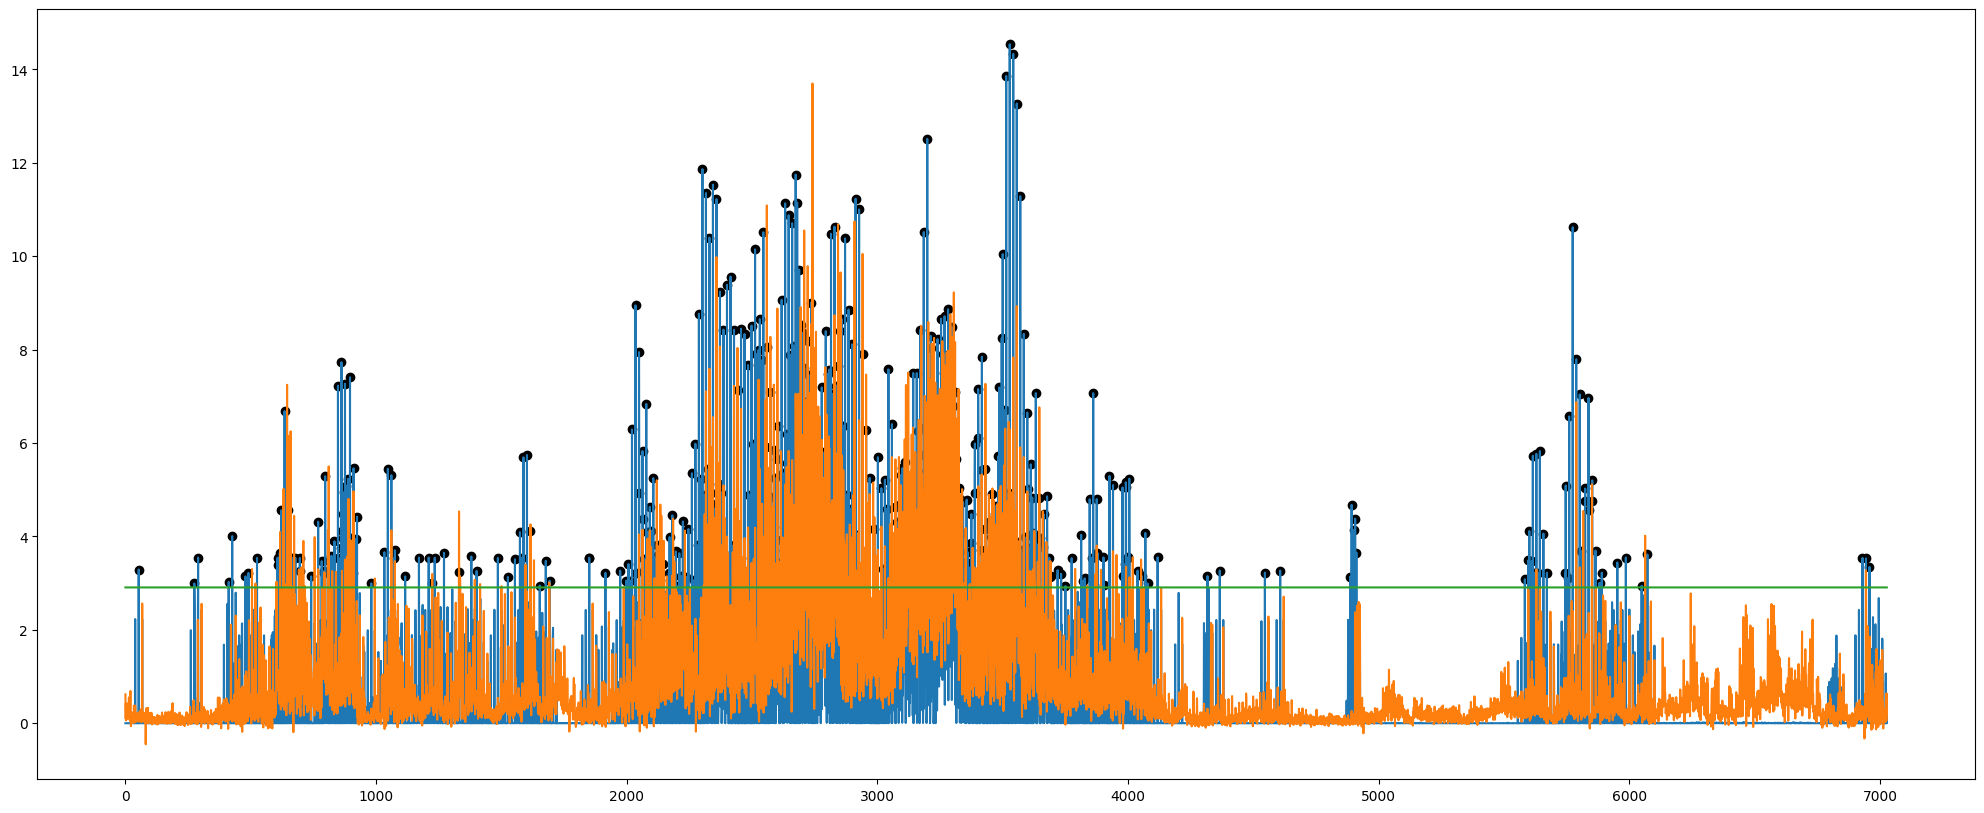

In [80]:
mask = np.argwhere(res[:, 3] == 1)
plt.figure(figsize=(25,10))
plt.plot(res[mask, 8])
plt.plot(res[mask, 9])
plt.plot(np.arange(0, res[mask].shape[0]), np.full(res[mask].shape[0], 0.2 *  np.nanmax(res[mask, 8])))
x = np.argwhere(res[mask, 8] > 0.2 *  np.nanmax(res[mask, 8]))[:, 0]
plt.scatter(x, res[mask, 8][x], c='black')

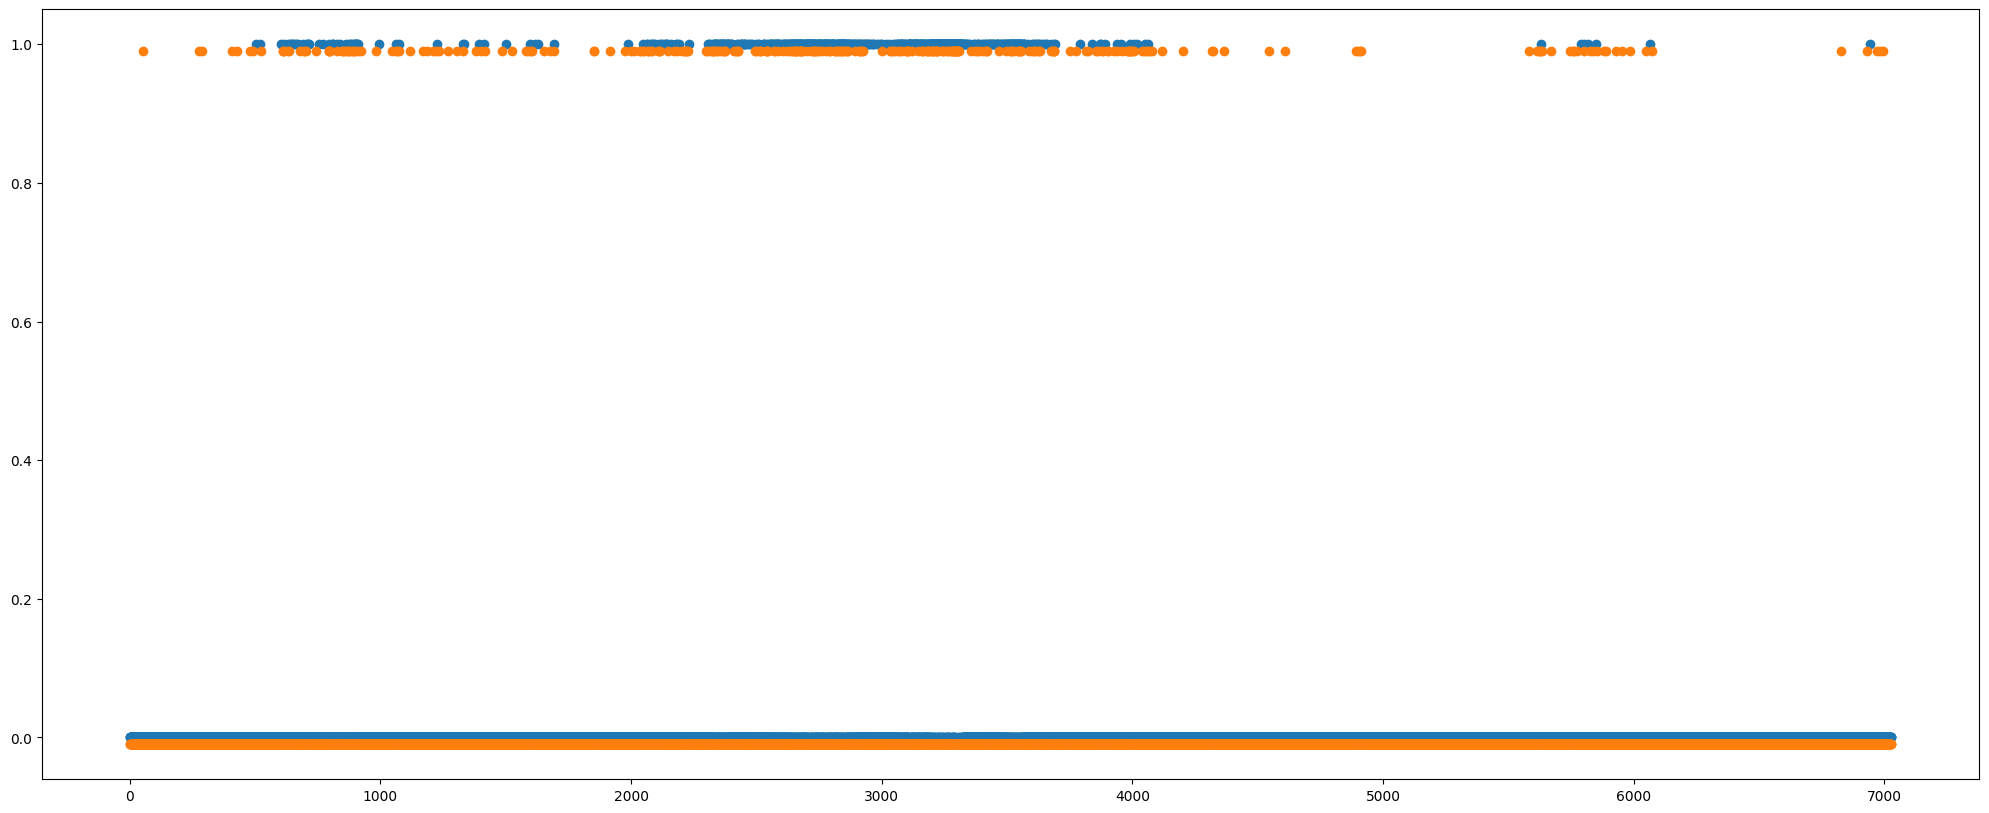

In [97]:
plt.figure(figsize=(25,10))
yBinPred = (res[mask, 9] > 0.2 *  np.nanmax(res[mask, 8])).astype(int)
plt.scatter(np.arange(0, res[mask, 9].shape[0]), yBinPred)
plt.scatter(np.arange(0, res[mask, 9].shape[0]), (res[mask, 7] > 0) - 0.01)

In [92]:
f1_score(res[mask, 7] > 0, yBinPred, sample_weight=np.ones(yBinPred.shape))

0.20135746606334842

In [49]:
res[mask][res[mask, 8] > np.nanmax(res[mask, 8]) * 0.9][:, 7]

array([3., 2., 2., 1.])

In [98]:
my_f1_score(res[mask, :9].reshape(-1, 9), res[mask, 9], isBin=False, weights=None)

(0.20135746606334842,
 0.1555944055944056,
 0.28525641025641024,
 0.2,
 2.907196205989703)

In [3]:
allMonth = [date.split('-')[1] for date in allDates]

In [9]:
def order_class(predictor, pred):
    res = np.zeros(pred[~np.isnan(pred)].shape[0], dtype=int)
    cc = predictor.kmeans.cluster_centers_.reshape(-1)
    classes = np.arange(cc.shape[0])
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    for c in range(cc.shape[0]):
        mask = np.argwhere(pred == classes[c])
        res[mask] = c
    return res

<Axes: xlabel='departement'>

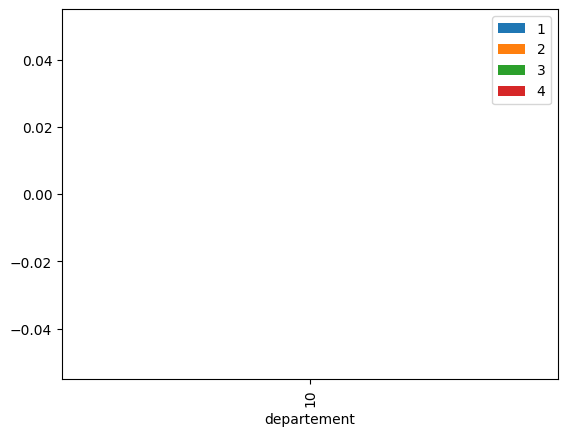

In [ ]:
def plot_from_dict(dico):
    df = pd.DataFrame(index=np.arange(len(dico)), columns=['departement', '1', '2', '3', '4'])
    i = 0
    for key, values in dico.items():
        try:
            df.loc[i, 'departement'] = key
            values = values['class']
            if 0 in values.keys():
                df.loc[i, '0'] = values[0][-1]
            else:
                df.loc[i, '0'] = 0

            if 1 in values.keys():
                df.loc[i, '1'] = values[1][-1]
            else:
                df.loc[i, '1'] = 0
                
            if 2 in values.keys():
                df.loc[i, '2'] = values[2][-1]
            else:
                df.loc[i, '2'] = 0

            if 3 in values.keys():
                df.loc[i, '3'] = values[3][-1]
            else:
                df.loc[i, '3'] = 0

            if 4 in values.keys():
                df.loc[i, '4'] = values[4][-1]
            else:
                df.loc[i, '4'] = 0
            i += 1
        except:
            continue
    return df 

df = plot_from_dict(classs)
df.index = df.departement
df.plot.bar()

### Pred vs real

<Axes: >

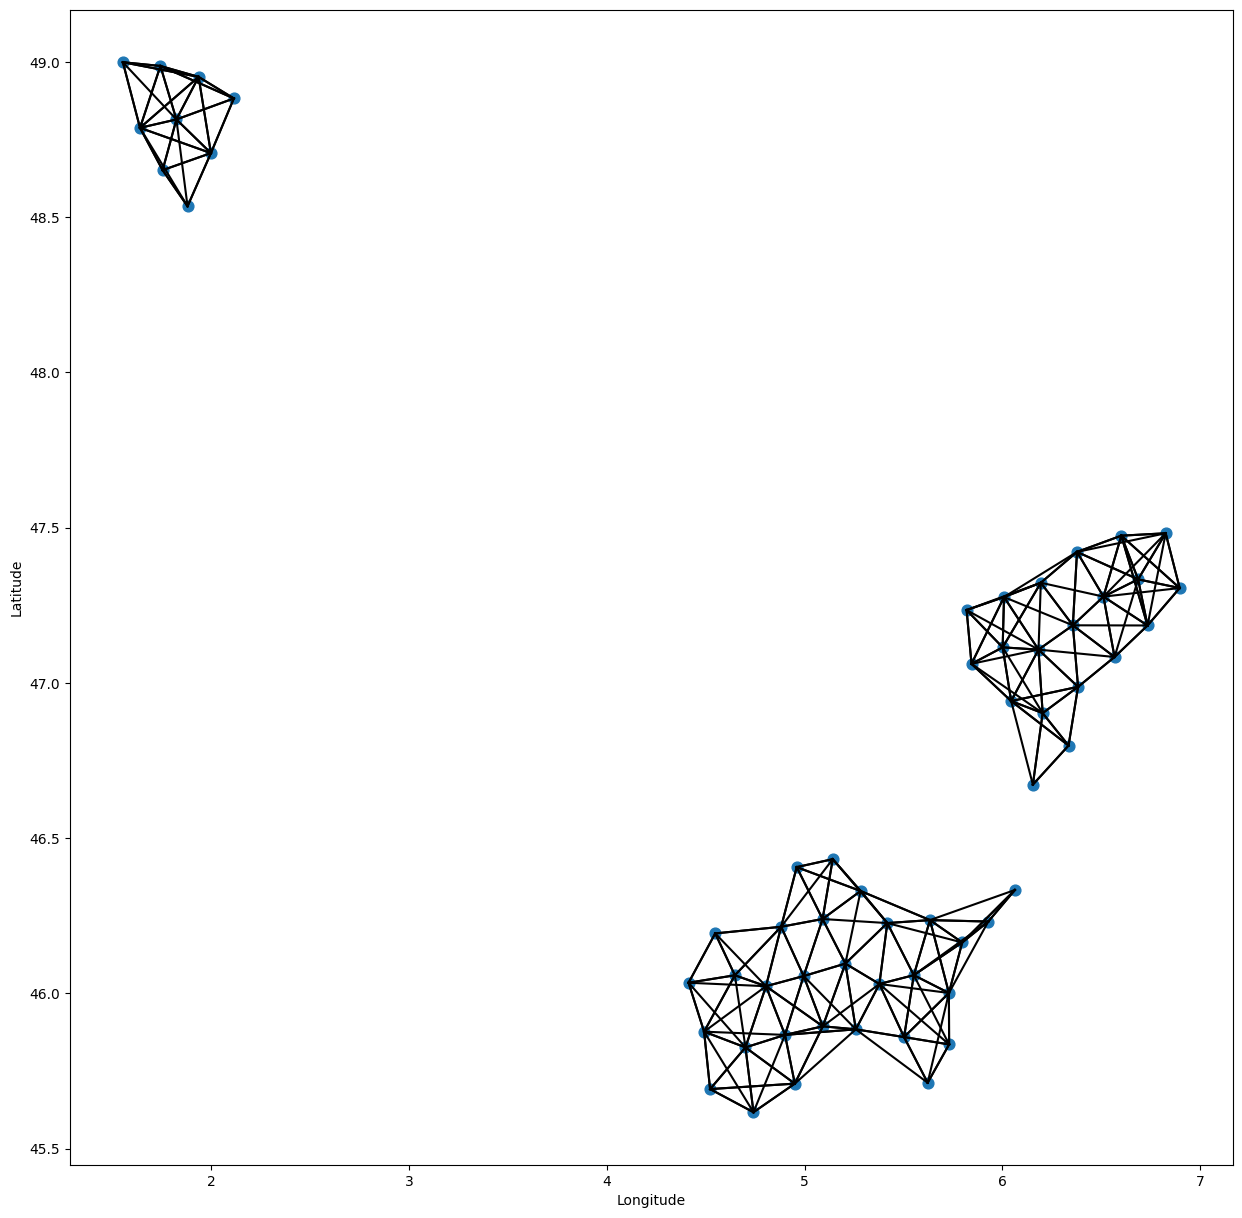

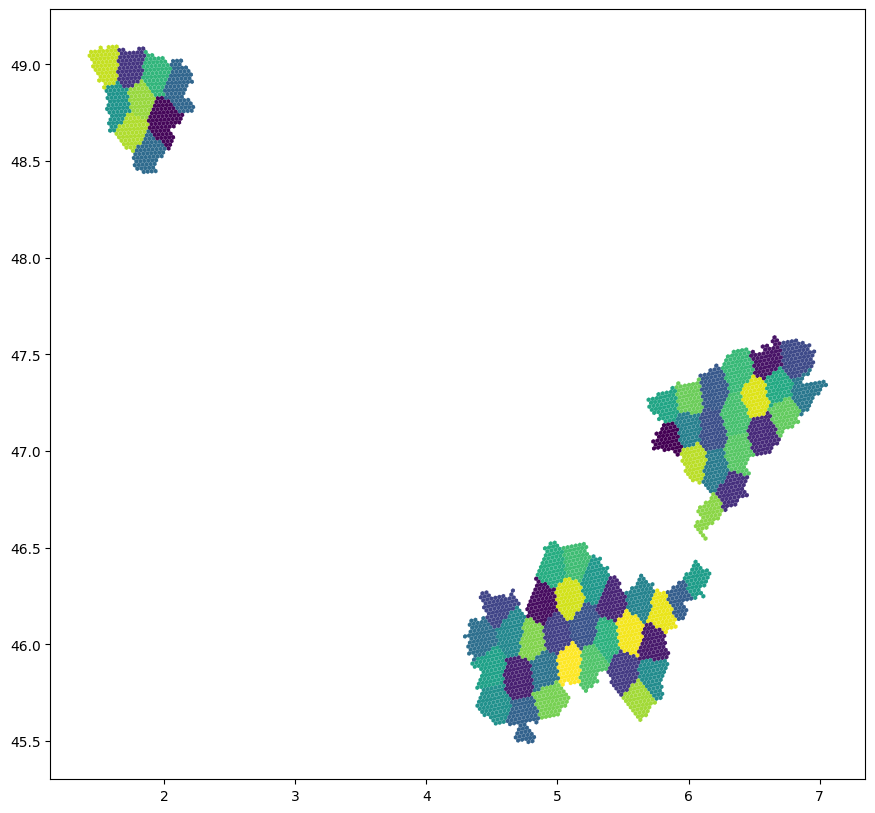

In [ ]:
nt = 'Doubs'
scale = '10'
scaling = 'z-score'
encoding = 'Catboost'
name = "exp1/inondation"
test = Path(name+'/test/'+ nt)

n = 'graph_'+scale+'.pkl'
graph = read_object(n, test)
region = gpd.read_file('regions.geojson')
Xk = list(zip(region.longitude, region.latitude))
region['scale'] = graph._predict_node(Xk)
graph._plot(nodes=graph.nodes)
fig, ax = plt.subplots(1, figsize=(15,10))
region.plot(column='scale', ax=ax)

In [ ]:
metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
try:
    metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
    metrics.update(metrics_dl)
except:
    pass
try:
    metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
    metrics.update(metrics_dl)
except:
    pass

X = read_object('X_7_'+scale+'.pkl', test)
Y = read_object('Y_7_'+scale+'.pkl', test)
Ypred = read_object('xgboost_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_pred.pkl', test)
YBin = np.copy(Y)
YBin[:,-2] = Y[:, -2]
YBin = YBin[Y[:,-3] > 0]
X = X[Y[:,-3] > 0]
Y = Y[Y[:,-3] > 0]

exp1/inondation/test/Doubs/metrics_100_7_10_dummy_10_z-score_Catboost_Doubs.pkl not found
exp1/inondation/test/Doubs/metrics_100_7_10_10_z-score_Catboost_Doubs_dl.pkl not found


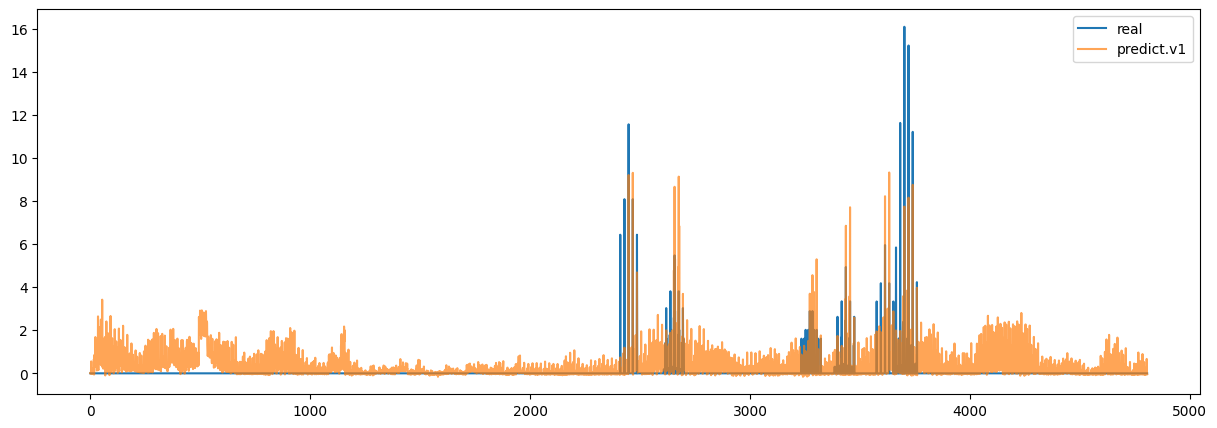

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Ypred[:,7], label='real')
plt.plot(Ypred[:,8], label='predict.v1', alpha=0.7)
plt.legend()

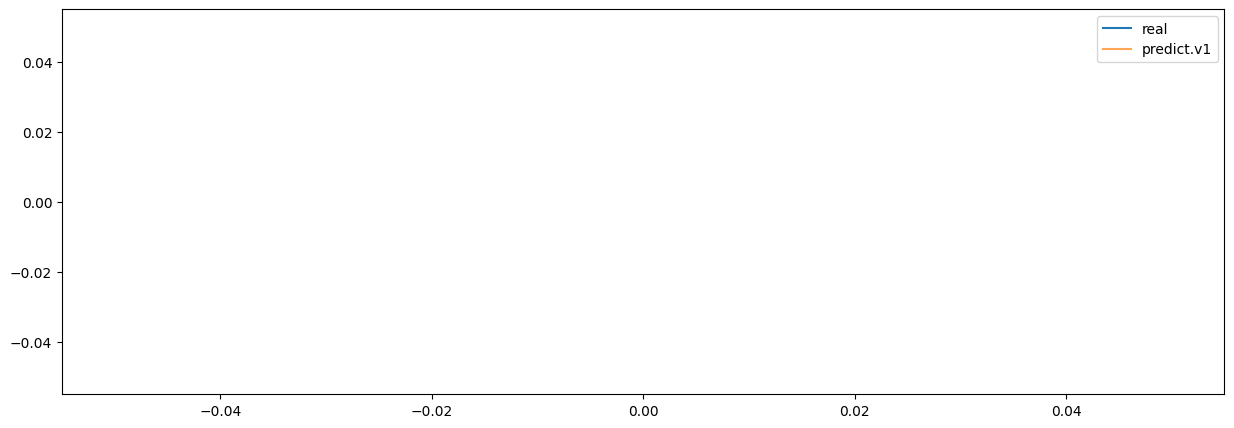

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Ypred[Ypred[:,3] == 1][:,7], label='real')
plt.plot(Ypred[Ypred[:,3] == 1][:,8], label='predict.v1', alpha=0.7)
plt.legend()

In [ ]:
"""plt.figure(figsize=(15,5))
plt.plot(Ypred[Ypred[:,3] == 1][:,6], label='real')
plt.plot(Ypred3[Ypred[:,3] == 1][:,8], label='predict.v1', alpha=0.7)
plt.plot(Ypred4[Ypred[:,3] == 1][:,8], label='predict.v2',  alpha=0.7)
plt.legend()"""

"plt.figure(figsize=(15,5))\nplt.plot(Ypred[Ypred[:,3] == 1][:,6], label='real')\nplt.plot(Ypred3[Ypred[:,3] == 1][:,8], label='predict.v1', alpha=0.7)\nplt.plot(Ypred4[Ypred[:,3] == 1][:,8], label='predict.v2',  alpha=0.7)\nplt.legend()"

In [ ]:
"""plt.figure(figsize=(15,5))
plt.plot(Ypred[Ypred[:,3] == 1][:,7], label='real')
plt.plot(Ypred3[Ypred[:,3] == 1][:,8], label='predict.v1', alpha=0.7)
plt.plot(Ypred4[Ypred[:,3] == 1][:,8], label='predict.v2',  alpha=0.7)
plt.plot(Ypred[Ypred[:,3] == 1][:,6], label='real')
plt.legend()"""

"plt.figure(figsize=(15,5))\nplt.plot(Ypred[Ypred[:,3] == 1][:,7], label='real')\nplt.plot(Ypred3[Ypred[:,3] == 1][:,8], label='predict.v1', alpha=0.7)\nplt.plot(Ypred4[Ypred[:,3] == 1][:,8], label='predict.v2',  alpha=0.7)\nplt.plot(Ypred[Ypred[:,3] == 1][:,6], label='real')\nplt.legend()"

In [ ]:
def find_worst_date_by_dept(departement, Ypred, weighted, plot, num):
    ydep = Ypred[Ypred[:,3] == name2int[departement]]
    if weighted:
        ind = np.lexsort([ydep[:,-2]])
        ind = np.flip(ind)
        res = ydep[ind][:, -2]
    else:
        ind = np.lexsort([ydep[:,-1]])
        ind = np.flip(ind)
        res = ydep[ind][:, -1]
    
    order = ydep[ind]
    orderDate = [allDates[int(di)] for di in order[:,4]]
    if plot:
        plt.figure(figsize=(15,5))
        plt.title(departement)
        plt.plot(ydep[:,7][ind][:num], label='real')
        plt.plot(ydep[:,-3][ind][:num], label='predict', alpha=0.5)
        plt.legend()
    return orderDate[:num], order[:,4][:num], order[:,0][:num], res[:num]

def find_best_date_by_dept(departement, Ypred, weighted, plot, num):
    ydep = Ypred[Ypred[:,3] == name2int[departement]]
    if weighted:
        ind = np.lexsort([ydep[:,-2]])
        res = ydep[ind][:, -2]
    else:
        ind = np.lexsort([ydep[:,-1]])
        res = ydep[ind][:, -1]
    
    order = ydep[ind]
    orderDate = [allDates[int(di)] for di in order[:,4]]
    if plot:
        plt.figure(figsize=(15,5))
        plt.title(departement)
        plt.plot(ydep[:,7][ind][:num], label='real')
        plt.plot(ydep[:,-3][ind][:num], label='predict', alpha=0.5)
        plt.legend()
    return orderDate[:num], order[:,4][:num], order[:,0][:num], res[:num]

def my_bincount(array):
    array = array.astype(int)
    return np.bincount(array)

"""plot = False
ain, ainBin, ainID, rmseA = find_worst_date_by_dept('departement-01-ain', Ypred, True, plot, 100)
yvelines, yvelinesBin, yvelinesID, rmseY = find_worst_date_by_dept('departement-78-yvelines', Ypred, True, plot, 100)
doubs, doubsBin, doubsID, rmseD = find_worst_date_by_dept('departement-25-doubs', Ypred, True, plot, 100)
(ain[0], rmseA[0]), (doubs[0], rmseD[0]), (yvelines[0], rmseY[0])
np.argmax(my_bincount(ainBin)), np.max(my_bincount(ainBin)), allDates[np.argmax(my_bincount(ainBin))]"""

"plot = False\nain, ainBin, ainID, rmseA = find_worst_date_by_dept('departement-01-ain', Ypred, True, plot, 100)\nyvelines, yvelinesBin, yvelinesID, rmseY = find_worst_date_by_dept('departement-78-yvelines', Ypred, True, plot, 100)\ndoubs, doubsBin, doubsID, rmseD = find_worst_date_by_dept('departement-25-doubs', Ypred, True, plot, 100)\n(ain[0], rmseA[0]), (doubs[0], rmseD[0]), (yvelines[0], rmseY[0])\nnp.argmax(my_bincount(ainBin)), np.max(my_bincount(ainBin)), allDates[np.argmax(my_bincount(ainBin))]"

In [ ]:
#np.argmax(my_bincount(yvelinesBin)), np.max(my_bincount(yvelinesBin)), allDates[np.argmax(my_bincount(yvelinesBin))], np.unique(yvelinesID)

In [ ]:
#np.argmax(my_bincount(doubsBin)), np.max(my_bincount(doubsBin)),  allDates[np.argmax(my_bincount(doubsBin))], np.unique(doubsID)

In [ ]:
"""plt.figure(figsize=(15,10))
plt.scatter(ain, rmseA)
plt.xticks(rotation=90)
plt.show()"""

'plt.figure(figsize=(15,10))\nplt.scatter(ain, rmseA)\nplt.xticks(rotation=90)\nplt.show()'

In [ ]:
"""plot = False
ain, ainBin, ainID, rmseA = find_best_date_by_dept('departement-01-ain', Ypred, True, plot, 100)
yvelines, yvelinesBin, yvelinesID, rmseY = find_best_date_by_dept('departement-78-yvelines', Ypred, True, plot, 100)
doubs, doubsBin, doubsID, rmseD = find_best_date_by_dept('departement-25-doubs', Ypred, True, plot, 100)
(ain[0], rmseA[0]), (doubs[0], rmseD[0]), (yvelines[0], rmseY[0])
np.argmax(my_bincount(ainBin)), np.max(my_bincount(ainBin)), allDates[np.argmax(my_bincount(ainBin))]

plt.figure(figsize=(15,10))
plt.scatter(ain, rmseA)
plt.xticks(rotation=90)
plt.show()"""

"plot = False\nain, ainBin, ainID, rmseA = find_best_date_by_dept('departement-01-ain', Ypred, True, plot, 100)\nyvelines, yvelinesBin, yvelinesID, rmseY = find_best_date_by_dept('departement-78-yvelines', Ypred, True, plot, 100)\ndoubs, doubsBin, doubsID, rmseD = find_best_date_by_dept('departement-25-doubs', Ypred, True, plot, 100)\n(ain[0], rmseA[0]), (doubs[0], rmseD[0]), (yvelines[0], rmseY[0])\nnp.argmax(my_bincount(ainBin)), np.max(my_bincount(ainBin)), allDates[np.argmax(my_bincount(ainBin))]\n\nplt.figure(figsize=(15,10))\nplt.scatter(ain, rmseA)\nplt.xticks(rotation=90)\nplt.show()"

### Rest

In [ ]:
def my_display(metrics, model):
    display(metrics[model])

In [ ]:
evaluate_class(metrics, 'departement-69-rhone', scale)

/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-69-rhonePredictor10.pkl not found
/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-69-rhonePredictor10.pkl not found


,model,1,2,3,4
0,xgboost,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


In [ ]:
evaluate_class(metrics, 'departement-01-ain', scale)

/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-01-ainPredictor10.pkl not found
/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-01-ainPredictor10.pkl not found


,model,1,2,3,4
0,xgboost,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


In [ ]:
evaluate_class(metrics, 'departement-25-doubs', scale)

,model,1,2,3,4,0
0,GT,0.375,0.6,0,0,0.001
1,xgboost,0.5,0,0,0,0.001


In [ ]:
evaluate_class(metrics, 'departement-78-yvelines', scale)

/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-78-yvelinesPredictor10.pkl not found
/home/caron/Bureau/Model/HexagonalScale/Prediction/GNN/exp1/inondation/train/influenceClustering/departement-78-yvelinesPredictor10.pkl not found


,model,1,2,3,4
0,xgboost,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


In [ ]:
evaluate_f1(metrics, 'f1')

,model,f1,prec,rec,tresh
0,GT,0.691983,0.753021,0.640099,0.3
1,xgboost,0.752356,0.694986,0.820049,0.4


In [ ]:
evaluate_f1(metrics, 'f1no_weighted')

,model,f1,prec,rec,tresh
0,GT,0.592593,0.421053,1.0,0.1
1,xgboost,0.666667,0.6,0.75,0.4


In [ ]:
evaluate_met(metrics, 'rmse')

,model,rmse
0,GT,0.0
1,xgboost,0.7208453


In [ ]:
cadf = evaluate_ca(metrics, 'ca')
gp = cadf.groupby('model')['ca'].mean().reset_index().sort_values('ca')
gp

,model,ca
1,xgboost,0.994
0,GT,1.0


In [ ]:
Y[np.argwhere(Y[:,-2] == np.max(Y[:,-2])), 4][:,0].astype(int)

array([2156, 2222])

In [ ]:
def varying_scale(scales, nt, scaling, encoding, departements, dummy):
    test = Path('test/'+ nt)

    # F1 score
    f1s = []
    for scale in scales:
        if not dummy:
            metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        else:
            metrics = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        f1 = evaluate_f1(metrics, 'f1')
        f1['scale'] = int(scale)
        f1s.append(f1)
    f1s = pd.concat(f1s).reset_index(drop=True)
    f1s.index = f1s.scale

    # RMSE score
    rmses = []
    for scale in scales:
        if not dummy:
            metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        else:
            metrics = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        rmse = evaluate_met(metrics, 'rmse')
        rmse['scale'] = int(scale)
        rmses.append(rmse)
    
    rmses = pd.concat(rmses).reset_index(drop=True)
    rmses['rmse'] = rmses['rmse'].astype(float) 
    rmses.index = rmses.scale

    # MAE
    cas = []
    for scale in scales:
        if not dummy:
            metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        else:
            metrics = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        cadf =  evaluate_ca(metrics, 'meac')
        gp = cadf.groupby('model')['meac'].mean().reset_index().sort_values('meac')
        gp['scale'] = int(scale)
        cas.append(gp)
    
    cas = pd.concat(cas).reset_index(drop=True)
    cas['meac'] = cas['meac'].astype(float) 
    cas.index = cas.scale

    # Balanced Class accuracy
    bcas = []
    for scale in scales:
        if not dummy:
            metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        else:
            metrics = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
            try:
                metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                metrics.update(metrics_dl)
            except Exception as e:
                pass
        cadf =  evaluate_ca(metrics, 'bca')
        gp = cadf.groupby('model')['bca'].mean().reset_index().sort_values('bca')
        gp['scale'] = int(scale)
        bcas.append(gp)
    
    bcas = pd.concat(bcas).reset_index(drop=True)
    bcas['bca'] = bcas['bca'].astype(float)
    bcas.index = bcas.scale

    # Mean fire
    classes = []
    for scale in scales:
        cl = []
        for departement in departements:
            if not dummy:
                metrics = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
                try:
                    metrics_dl = read_object('metrics_100_7_'+str(scale)+'_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                    metrics.update(metrics_dl)
                except Exception as e:
                    pass
            else:
                metrics = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'.pkl', test)
                try:
                    metrics_dl = read_object('metrics_100_7_'+str(scale)+'_dummy_'+str(scale)+'_'+scaling+'_'+encoding+'_'+nt+'_dl.pkl', test)
                    metrics.update(metrics_dl)
                except Exception as e:
                    pass
            classe = evaluate_class(metrics, departement, scale)
            classe['scale'] = int(scale)
            classe['departement'] = departement
            cl.append(classe)
        cl = pd.concat(cl)
        print(cl.columns)
        gp = cl.groupby('model')[cl.columns[np.isin(cl.columns, ['0', '1', '2', '3', '4'])]].mean().reset_index()
        gp['scale'] = int(scale)
        classes.append(gp)

    classes = pd.concat(classes).reset_index(drop=True)
    classes.index = classes.scale

    return f1s, rmses, classes, cas, bcas

In [ ]:
f1, rmse, classes, mae, bca = varying_scale(['10', '7', '5', '3'], '69', 'z-score', 'Catboost',
                                      ['departement-01-ain', 'departement-25-doubs',
                                       'departement-78-yvelines', 'departement-69-rhone'], False)

test/69/metrics_100_7_10_10_z-score_Catboost_69.pkl not found
test/69/metrics_100_7_10_10_z-score_Catboost_69_dl.pkl not found


TypeError: object of type 'NoneType' has no len()

In [ ]:
f1.sort_values('f1')

,model,f1,prec,rec,tresh,scale
scale,,,,,,
3,ST-GATCONV,0.098363,0.051725,1.0,0.1,3
3,ATGN,0.272398,0.304043,0.246719,0.1,3
7,ST-GATLTSM,0.311853,0.217883,0.548345,0.3,7
3,ST-GATLTSM,0.342004,0.457457,0.273083,0.1,3
3,GAT,0.343734,0.461206,0.273956,0.2,3
7,GAT,0.36171,0.289732,0.481272,0.3,7
5,ST-GATLTSM,0.371785,0.313912,0.45582,0.1,5
7,ATGN,0.401684,0.343323,0.483951,0.3,7
5,GAT,0.404404,0.363477,0.455716,0.3,5


In [ ]:
mae

,model,meac,scale
scale,,,
10,GT,0.000,10
10,ngboost,0.270,10
10,lightgbm,0.283,10
10,xgboost,0.290,10
10,ST-GATCONV,0.362,10
10,ST-GCNCONV,0.365,10
10,lightgbm_bin,0.411,10
10,xgboost_bin,0.425,10
10,ST-GATTCN,0.463,10


In [ ]:
f1 = f1[~f1['model'].isin(['perf_Y', 'perf_X'])]
mae = mae[~mae['model'].isin(['perf_Y', 'perf_X'])]
mae = mae[~mae['model'].isin(['perf_Y', 'perf_X'])]

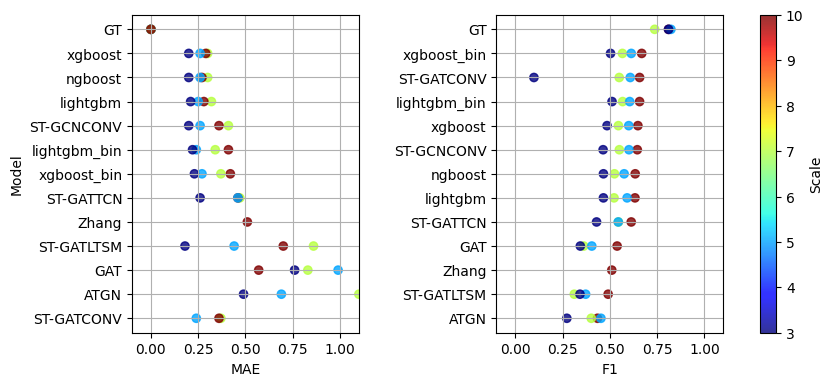

In [ ]:
# Les données du DataFrame
mae = mae.sort_values(by=['meac'], ascending=False)
scale = mae.scale.values
model = mae.model.values
f1s = np.round(mae['meac'].values, 2)

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

# Création du graphique
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)
ax[0].set_xlabel('MAE')
ax[0].set_ylabel('Model')
ax[0].set_xlim(-0.1,1.1)

ax[0].grid(True)

# Les données du DataFrame
scale = f1.scale.values
model = f1.model.values
f1s = f1.f1.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

scatter = ax[1].scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)

ax[1].set_xlabel('F1')
ax[1].set_xlim(-0.1,1.1)
ax[1].set_adjustable
ax[1].grid(True)

plt.tight_layout(pad=5)
fig.colorbar(scatter, label='Scale', ax=ax.ravel().tolist())
plt.show()

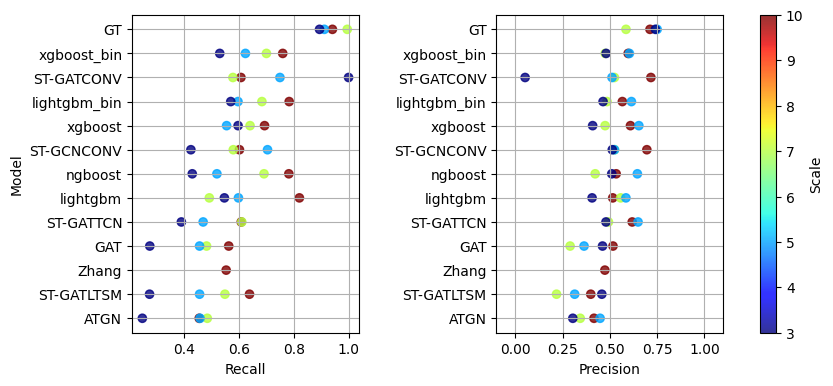

In [ ]:
# Les données du DataFrame
scale = f1.scale.values
model = f1.model.values
f1s = f1.rec.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

# Création du graphique
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Model')
ax[1].set_xlim(-0.1,1.1)

ax[0].grid(True)

# Les données du DataFrame
scale = f1.scale.values
model = f1.model.values
f1s = f1.prec.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

scatter = ax[1].scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)

ax[1].set_xlabel('Precision')
ax[1].set_xlim(-0.1,1.1)
ax[1].set_adjustable
ax[1].grid(True)

plt.tight_layout(pad=5)
fig.colorbar(scatter, label='Scale', ax=ax.ravel().tolist())
plt.show()

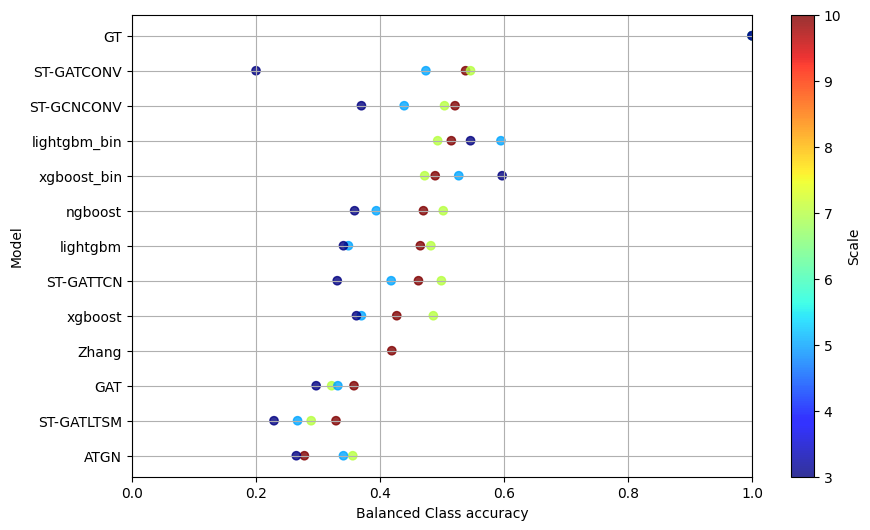

In [ ]:
# Les données du DataFrame
scale = bca.scale.values
model = bca.model.values
f1s = bca.bca.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)
plt.colorbar(label='Scale')
plt.xlabel('Balanced Class accuracy')
plt.ylabel('Model')
plt.xlim(0,1)

plt.grid(True)
plt.show()

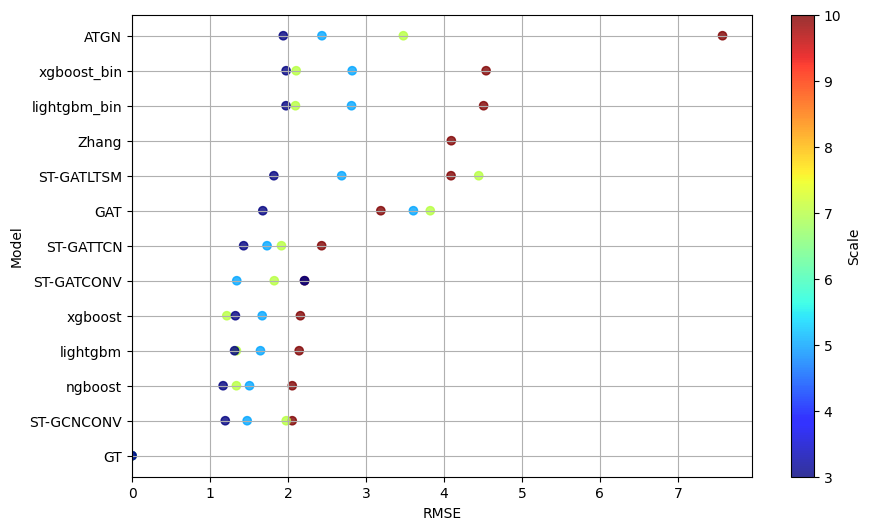

In [ ]:
# Les données du DataFrame
rmse.reset_index(inplace=True, drop=True)

scale = rmse.scale.values
model = rmse.model.values
f1s = rmse.rmse.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)
plt.colorbar(label='Scale')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.xlim(0)
plt.grid(True)
plt.show()

In [ ]:
test = read_object('departement-01-ainPredictorlightgbm_bin7.pkl', Path('influenceClustering'))
test.kmeans.cluster_centers_

array([[0.00327248],
       [0.18717992],
       [0.56422211],
       [0.32982379],
       [0.08255571]])

In [ ]:
classes = np.arange(5)
cc = test.kmeans.cluster_centers_.reshape(-1)
ind = np.lexsort([cc])
cc = cc[ind]
classes = classes[ind]
classes

array([0, 4, 1, 3, 2])

In [ ]:
classes[-4:]

array([4, 1, 3, 2])

In [ ]:
def order_class(n_class, predictor, dico, departement):
    classes = np.arange(n_class)
    cc = predictor.kmeans.cluster_centers_.reshape(-1)
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    res = {}
    #print(cc, classes)
    for c in range(n_class):
        if classes[c] in dico[departement].keys():
            res[c] = dico[departement][classes[c]]
        else:
            res[c] = (0, 0, 0)
    return res

In [ ]:
# Création du graphique
models = classes[classes['scale'] == 10]['model'].values
data = classes[classes['scale'] == 10][['0', '1', '2', '3', '4']].values
plt.figure(figsize=(12, 6))
for i in range(len(models)):
    plt.plot(data[i], marker='o', label=models[i])

plt.xlabel('Column')
plt.ylabel('Value')
plt.xticks(range(5), [0, 1, 2, 3, 4])
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

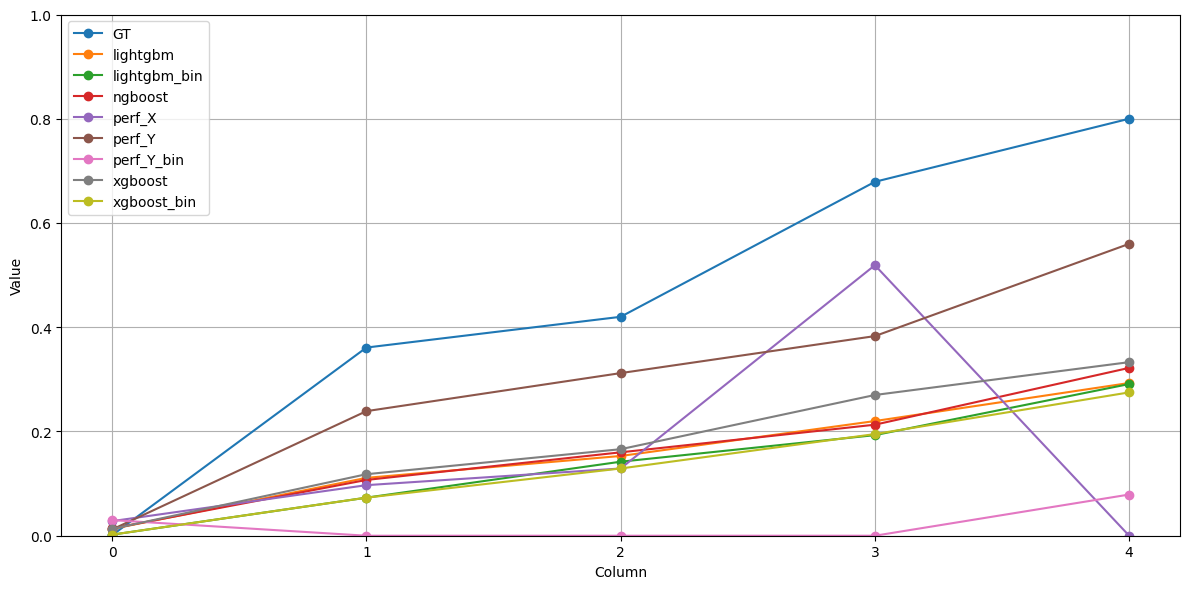

In [ ]:
# Création du graphique
models = classes[classes['scale'] == 7]['model'].values
data = classes[classes['scale'] == 7][['0', '1', '2', '3', '4']].values
plt.figure(figsize=(12, 6))
for i in range(len(models)):
    plt.plot(data[i], marker='o', label=models[i])

plt.xlabel('Column')
plt.ylabel('Value')
plt.xticks(range(5), [0, 1, 2, 3, 4])
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Les données du DataFrame
classes.reset_index(inplace=True, drop=True)

scale = classes.scale.values
model = classes.model.values
f1s = classes.rmse.values

model_scale = [f"{m}-{s}" for m, s in zip(model, scale)]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(f1s, model, c=scale, cmap='jet', alpha=0.8)
plt.colorbar(label='Scale')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.xlim(0)
plt.grid(True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'rmse'

In [ ]:
classes 

,model,1,2,3,4,0,scale,departement
scale,,,,,,,,
10,GT,0.209,0.38,0.533,0.667,0.004,10,departement-01-ain
10,xgboost,0.121,0.215,0.25,0.389,0.026,10,departement-01-ain
10,lightgbm,0.125,0.203,0.25,0.318,0.026,10,departement-01-ain
10,ngboost,0.133,0.194,0.239,0.318,0.027,10,departement-01-ain
10,xgboost_bin,0.089,0.131,0.25,0.283,0.001,10,departement-01-ain
10,lightgbm_bin,0.085,0.137,0.206,0.304,0.001,10,departement-01-ain
10,xgboost_bin_unweighted,0.061,0.105,0.167,0.304,0.000,10,departement-01-ain
10,lightgbm_bin_unweighted,0.065,0.128,0.172,0.27,0.000,10,departement-01-ain
10,perf_Y,0.186,0.251,0.333,0.5,0.019,10,departement-01-ain


/tmp/ipykernel_205582/3835579135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('scale', inplace=True, axis=1)


<Axes: xlabel='model,scale'>

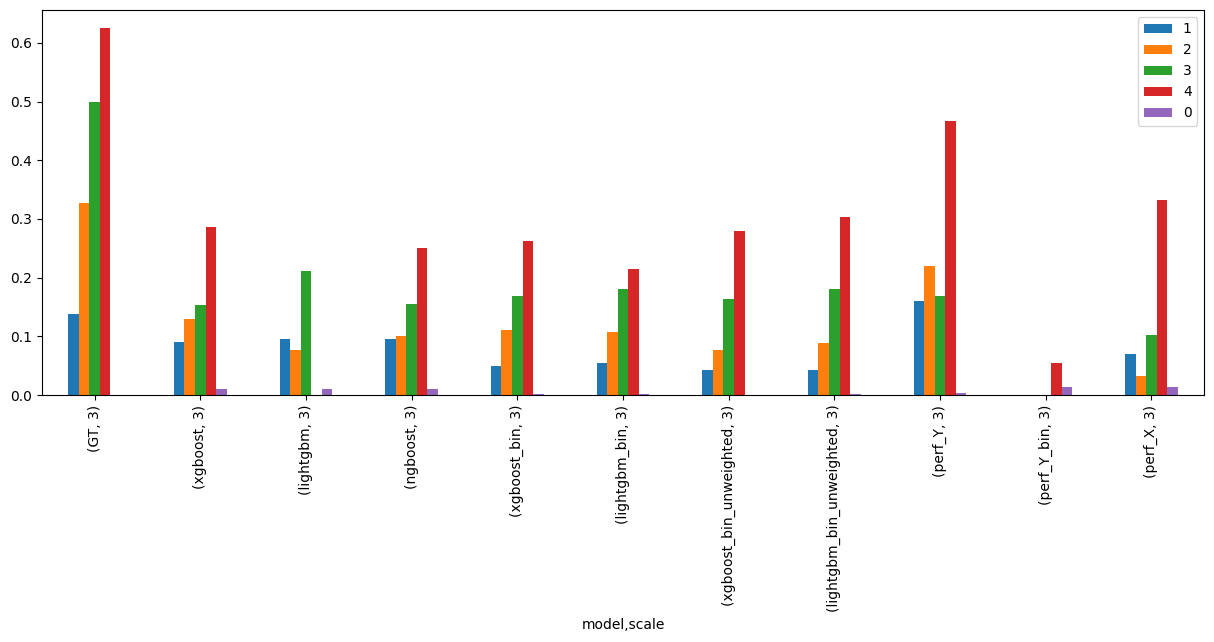

In [ ]:
_, ax = plt.subplots(1, figsize=(15, 5))

test = classes[(classes['departement'] == 'departement-01-ain') & (classes['scale'] == 3)]
test.index = pd.MultiIndex.from_arrays((test.model, test.scale))
test.drop('scale', inplace=True, axis=1)
test.plot.bar(ax=ax)

/tmp/ipykernel_205582/789484259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('scale', inplace=True, axis=1)


<Axes: xlabel='model,scale'>

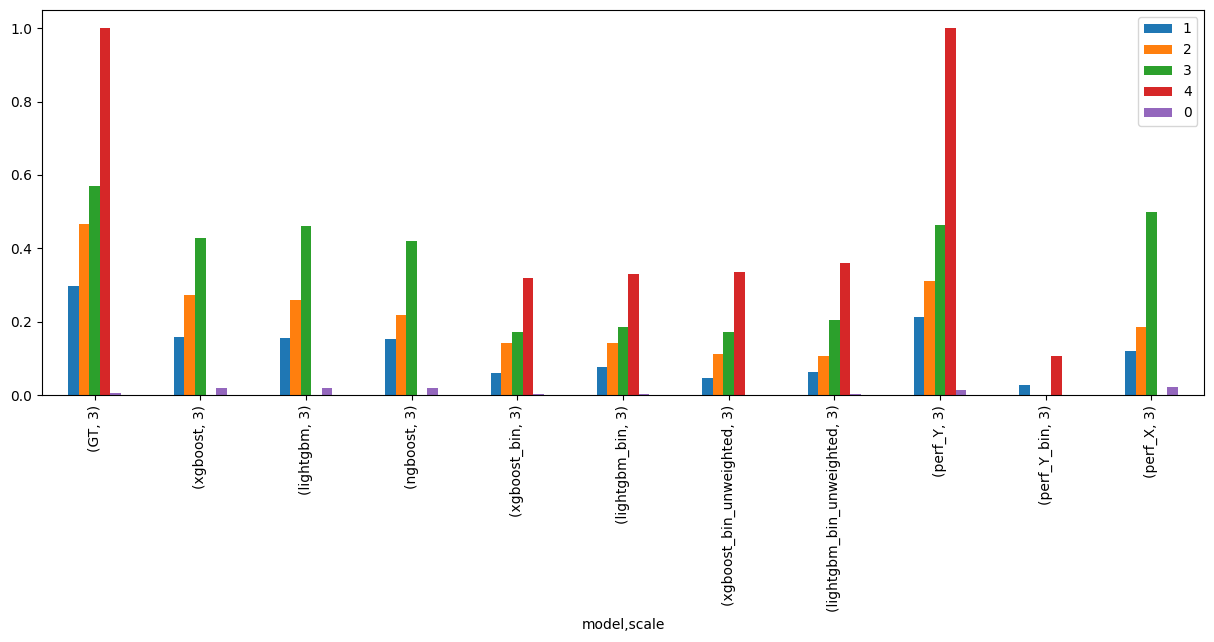

In [ ]:
_, ax = plt.subplots(1, figsize=(15, 5))

test = classes[(classes['departement'] == 'departement-78-yvelines') & (classes['scale'] == 3)]
test.index = pd.MultiIndex.from_arrays((test.model, test.scale))
test.drop('scale', inplace=True, axis=1)
test.plot.bar(ax=ax)

/tmp/ipykernel_205582/4267324073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('scale', inplace=True, axis=1)


<Axes: xlabel='model,scale'>

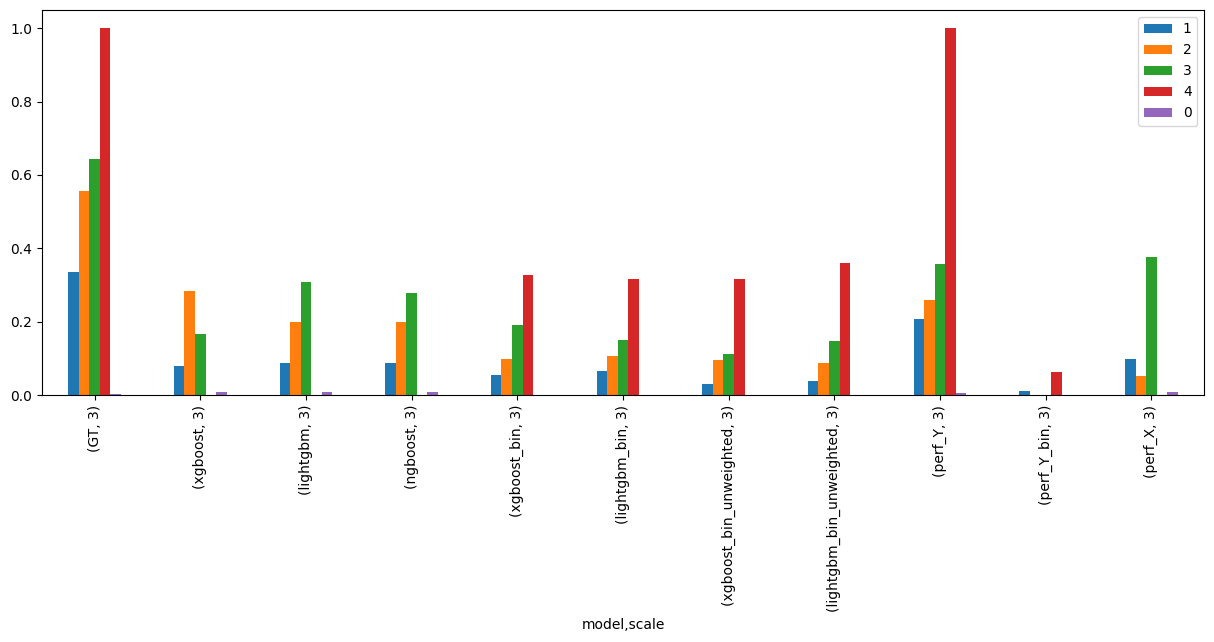

In [ ]:
_, ax = plt.subplots(1, figsize=(15, 5))

test = classes[(classes['departement'] == 'departement-25-doubs') & (classes['scale'] == 3)]
test.index = pd.MultiIndex.from_arrays((test.model, test.scale))
test.drop('scale', inplace=True, axis=1)
test.plot.bar(ax=ax)

In [ ]:
rmse[rmse['model'] == 'ST-GATTCN']

,model,rmse,scale


In [ ]:
date = allDates[2216]
date

'2023-07-07'

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

model = 'ST-GATCONV'

name = date+'.geojson'
geo = gpd.read_file(test / model / name)

fix, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].set_title('nbFire')
geo.plot(column='nbFire', ax=ax[0][0], vmin=0, vmax=1)
ax[0][1].set_title('gt')
geo.plot(column='gt', ax=ax[0][1], vmin=0, vmax=13)
ax[1][0].set_title('prediction')
geo.plot(column='prediction', ax=ax[1][0], vmin=0, vmax=13)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

<Axes: title={'center': 'prediction'}>

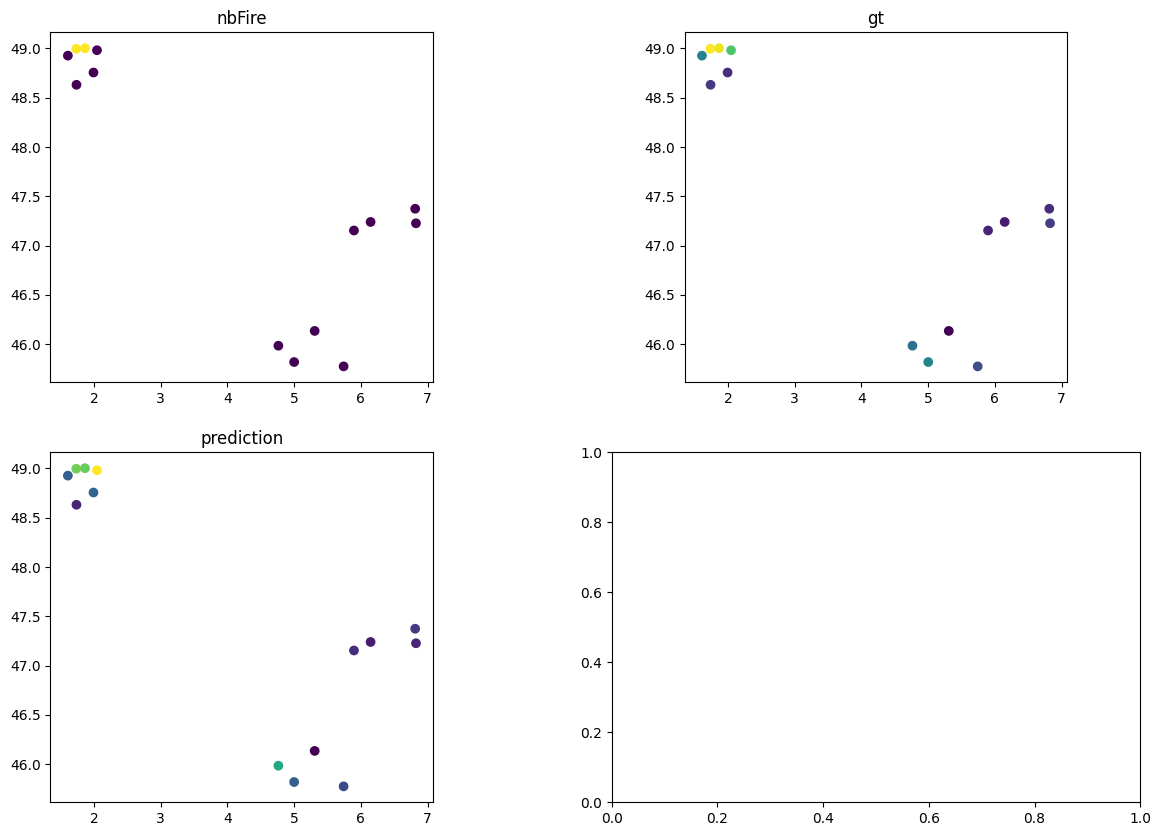

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

model = 'ST-GATTCN'

name = date+'.geojson'
geo = gpd.read_file(test / model / name)

fix, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].set_title('nbFire')
geo.plot(column='nbFire', ax=ax[0][0])
ax[0][1].set_title('gt')
geo.plot(column='gt', ax=ax[0][1])
ax[1][0].set_title('prediction')
geo.plot(column='prediction', ax=ax[1][0])

<Axes: title={'center': 'prediction'}>

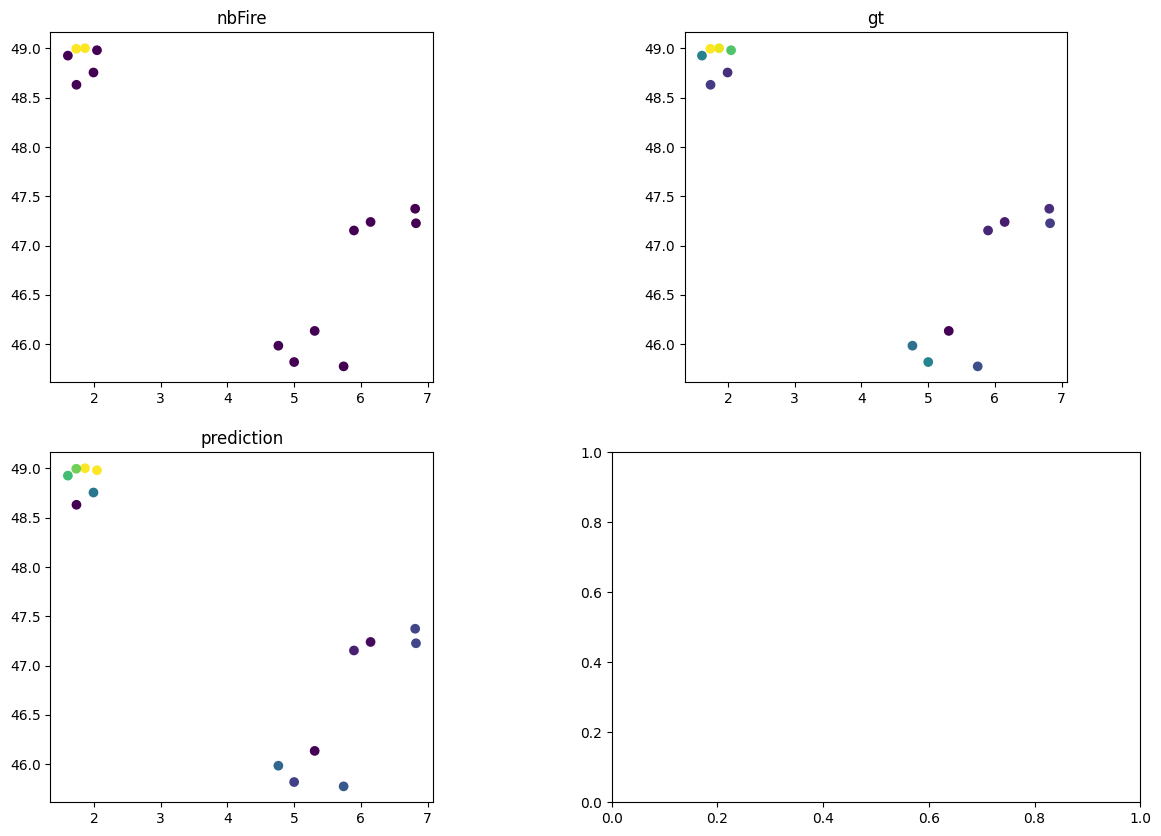

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

model = 'ATGN'

name = date+'.geojson'
geo = gpd.read_file(test / model / name)

fix, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].set_title('nbFire')
geo.plot(column='nbFire', ax=ax[0][0])
ax[0][1].set_title('gt')
geo.plot(column='gt', ax=ax[0][1])
ax[1][0].set_title('prediction')
geo.plot(column='prediction', ax=ax[1][0])